# Import Library

In [1]:
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import InceptionV3
import numpy as np
import matplotlib.pyplot as plt
import pathlib
import os
from tqdm import tqdm
import pandas as pd
from sklearn.model_selection import  train_test_split

# Set Up GPU

In [2]:
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
physical_dev = tf.config.experimental.list_physical_devices('GPU')
print("Num GPUs Available:", len(physical_dev))

Num GPUs Available: 1


# Import Data

In [4]:
data_path = '/content/drive/MyDrive/ai artificial CV A home project/googlenet'

In [5]:
url = 'https://drive.google.com/file/d/1QQ4HWQ0Zx-n6LBx19fI-OUCyzTYD5_t5/view?usp=drive_link'
file_id=url.split('/')[-2]
dwn_url='https://drive.google.com/uc?id=' + file_id
attr_list = pd.read_csv(dwn_url, delimiter= ' ', skipinitialspace= True, skiprows=1)
attr_list = attr_list.shift(-1, axis=1)
attr_list.insert(loc=0, column='img_number', value=np.arange(1,len(attr_list)+1))
attr_list = attr_list.drop(columns='Unnamed: 40')
attr_list = attr_list.replace(to_replace=-1, value=0)
# attr_list.index = attr_list['img_number'].astype(str).str.zfill(6) + '.jpg'
attr_list['img_number'] = attr_list['img_number'].apply(lambda x: str(x).zfill(6) + '.jpg')
display(attr_list.head())
print(attr_list.shape)

,img_number,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,...,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young
0,000001.jpg,0,1,1,0,0,0,0,0,0,...,0,1,1,0,1,0,1,0,0,1
1,000002.jpg,0,0,0,1,0,0,0,1,0,...,0,1,0,0,0,0,0,0,0,1
2,000003.jpg,0,0,0,0,0,0,1,0,0,...,0,0,0,1,0,0,0,0,0,1
3,000004.jpg,0,0,1,0,0,0,0,0,0,...,0,0,1,0,1,0,1,1,0,1
4,000005.jpg,0,1,1,0,0,0,1,0,0,...,0,0,0,0,0,0,1,0,0,1


(202599, 41)


In [6]:
final_data = attr_list[attr_list['img_number'].isin(os.listdir(data_path + '/Images'))]
print(f'Full Data: {attr_list.shape[0]} rows')
print(f'Filtered Data: {final_data.shape[0]} rows')

Full Data: 202599 rows
Filtered Data: 5000 rows


In [7]:
final_data = final_data[['img_number', 'Male']].reset_index(drop=True)
final_data['Gender'] = final_data['Male'].map({1: 'Male', 0: 'Female'})
final_data.drop(columns='Male', inplace=True)
final_data.head()

,img_number,Gender
0,000051.jpg,Male
1,000052.jpg,Male
2,000065.jpg,Male
3,000166.jpg,Male
4,000198.jpg,Female


In [8]:
shape_fem = final_data[final_data['Gender'] == 'Male'].shape[0]
tmp_data = final_data[final_data['Gender'] == 'Female']
tmp_data = tmp_data.drop(tmp_data.index[shape_fem:])
display(tmp_data.head())
tmp_data.shape

,img_number,Gender
4,000198.jpg,Female
5,000201.jpg,Female
6,000240.jpg,Female
14,000525.jpg,Female
19,000653.jpg,Female


(2047, 2)

In [9]:
final_data = final_data[final_data['Gender'] == 'Male']
final_data = pd.concat([final_data, tmp_data], ignore_index= True)
display(final_data.head())
final_data.shape

,img_number,Gender
0,000051.jpg,Male
1,000052.jpg,Male
2,000065.jpg,Male
3,000166.jpg,Male
4,000282.jpg,Male


(4094, 2)

In [10]:
img_train, img_val = train_test_split(final_data, test_size= 894, random_state= 40, stratify=final_data['Gender'])
img_val, img_test = train_test_split(img_val, test_size= 100, random_state= 40, stratify=img_val['Gender'])
print("Total Train Sample Images : ", len(img_train))
print("Total Validation Sample Images : ", len(img_val))
print("Total Test Sample Images : ", len(img_test))

Total Train Sample Images :  3200
Total Validation Sample Images :  794
Total Test Sample Images :  100


In [11]:
img_train

,img_number,Gender
2243,014543.jpg,Female
2012,197113.jpg,Male
1066,104576.jpg,Male
3604,106593.jpg,Female
1232,122143.jpg,Male
...,...,...
326,029736.jpg,Male
3568,103564.jpg,Female
3791,120372.jpg,Female
3651,109979.jpg,Female


# Build Model

In [12]:
tf.random.set_seed(42)

image_generator = ImageDataGenerator(
        rescale=1./255,
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

no_aug = ImageDataGenerator(rescale=1.0/255)

data_train = no_aug.flow_from_dataframe(img_train, data_path+'/Images',
                                        x_col= 'img_number',
                                        y_col = 'Gender',
                                        class_mode = 'binary',
                                        batch_size= 128,
                                        seed= 42,
                                        target_size= (224, 224))

data_valid = ImageDataGenerator(rescale=1.0/255)
data_test = ImageDataGenerator(rescale=1.0/255)

train_gen = image_generator.flow_from_dataframe(img_train, data_path+'/Images',
                                                   x_col= 'img_number',
                                                   y_col = 'Gender',
                                                   class_mode = 'binary',
                                                   batch_size= 32,
                                                   seed= 42,
                                                   target_size= (224, 224))
valid_gen = image_generator.flow_from_dataframe(img_val, data_path+'/Images',
                                                   x_col= 'img_number',
                                                   y_col = 'Gender',
                                                   class_mode = 'binary',
                                                   batch_size= 32,
                                                   seed= 42,
                                                   target_size= (224, 224))
test_gen = image_generator.flow_from_dataframe(img_test, data_path+'/Images',
                                                   x_col= 'img_number',
                                                   y_col = 'Gender',
                                                   class_mode = 'binary',
                                                   batch_size= 32,
                                                   seed= 42,
                                                   target_size= (224, 224))


Found 3200 validated image filenames belonging to 2 classes.
Found 3200 validated image filenames belonging to 2 classes.
Found 794 validated image filenames belonging to 2 classes.
Found 100 validated image filenames belonging to 2 classes.


In [13]:
#---- GoogleNet InceptionV3 -----
backbone = InceptionV3(
    input_shape=(224, 224, 3),
    include_top=False
)

model = tf.keras.Sequential([
    backbone,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [14]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 1)                 2049      
                                                                 
Total params: 21804833 (83.18 MB)
Trainable params: 21770401 (83.05 MB)
Non-trainable params: 34432 (134.50 KB)
_________________________________________________________________
None


In [15]:
model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

In [16]:
history = model.fit(
    train_gen,
    epochs=8,
    validation_data=valid_gen,
    verbose=1
)

Epoch 1/8
100/100 [==============================] - 114s 710ms/step - loss: 0.3541 - accuracy: 0.8509 - val_loss: 0.5563 - val_accuracy: 0.8010
Epoch 2/8
100/100 [==============================] - 68s 681ms/step - loss: 0.2062 - accuracy: 0.9147 - val_loss: 0.2940 - val_accuracy: 0.9106
Epoch 3/8
100/100 [==============================] - 66s 664ms/step - loss: 0.1669 - accuracy: 0.9316 - val_loss: 0.2530 - val_accuracy: 0.9093
Epoch 4/8
100/100 [==============================] - 68s 681ms/step - loss: 0.1438 - accuracy: 0.9425 - val_loss: 0.1938 - val_accuracy: 0.9194
Epoch 5/8
100/100 [==============================] - 68s 684ms/step - loss: 0.1445 - accuracy: 0.9425 - val_loss: 0.3150 - val_accuracy: 0.8552
Epoch 6/8
100/100 [==============================] - 67s 665ms/step - loss: 0.1257 - accuracy: 0.9531 - val_loss: 0.2427 - val_accuracy: 0.9118
Epoch 7/8
100/100 [==============================] - 68s 672ms/step - loss: 0.1330 - accuracy: 0.9463 - val_loss: 0.1581 - val_accuracy

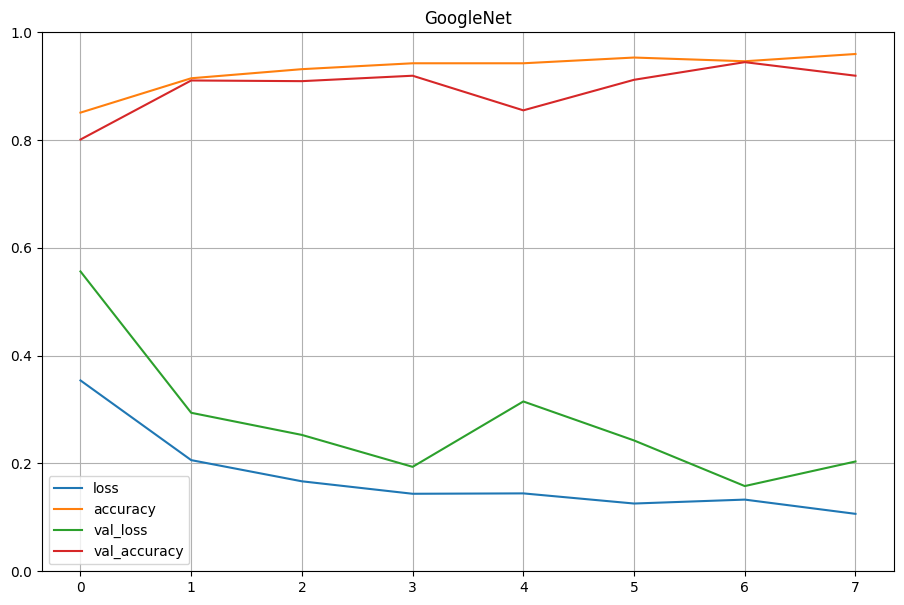

In [17]:
fig, ax = plt.subplots(figsize=(11, 7))
pd.DataFrame(history.history).plot(ax=ax)
ax.grid(True)
ax.set_ylim(0, 1)
ax.set_title("GoogleNet")
plt.show()

# Evaluation

In [18]:
model.evaluate(test_gen)

4/4 [==============================] - 2s 643ms/step - loss: 0.1924 - accuracy: 0.9100


[0.1924256533384323, 0.9100000262260437]

In [19]:
classify_1 = model.predict(test_gen, steps= np.ceil(len(img_test)/(30)))

4/4 [==============================] - 3s 473ms/step


In [38]:
prediction = classify_1.argmax(axis=1)
# img_test['Prediction'] = ["Male" if ele == 1 else "Female" for ele in prediction]
classify_1.shape

(100, 1)

In [39]:
prediction = classify_1.argmax(axis=1)
img_test['Prediction'] = ["Male" if ele == 1 else "Female" for ele in prediction]
img_test

,img_number,Gender,Prediction
1275,125989.jpg,Male,Female
2940,062130.jpg,Female,Female
3161,076604.jpg,Female,Female
1186,117232.jpg,Male,Female
3282,085250.jpg,Female,Female
...,...,...,...
232,021659.jpg,Male,Female
1323,130855.jpg,Male,Female
1153,113880.jpg,Male,Female
2273,016633.jpg,Female,Female


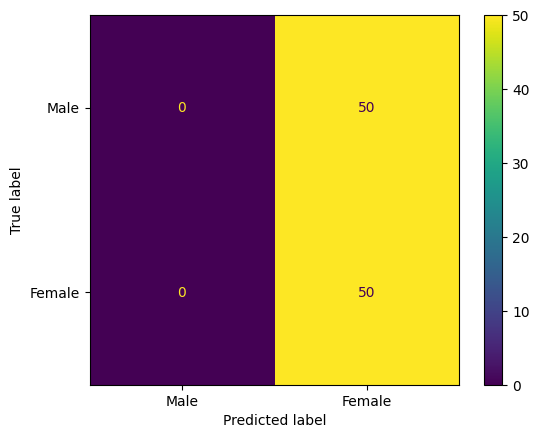

In [40]:
labels = ['Male','Female']

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(img_test['Gender'], img_test["Prediction"], labels= labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=labels)
disp.plot()
plt.show()

In [41]:
from sklearn.metrics import f1_score

# After model prediction on validation data
y_pred = model.predict(valid_gen)
optimal_threshold = 0.5  # Initial threshold

f1_scores = []
thresholds = np.arange(0.1, 1.0, 0.1)
for threshold in thresholds:
    y_pred_binary = (y_pred > threshold).astype(int)
    f1 = f1_score(valid_gen.classes, y_pred_binary)
    f1_scores.append(f1)

optimal_threshold = thresholds[np.argmax(f1_scores)]
print("Optimal Threshold:", optimal_threshold)

25/25 [==============================] - 13s 520ms/step
Optimal Threshold: 0.1


In [42]:
y_pred_test = (model.predict(test_gen) >= 0.1).astype(int)
img_test['Prediction'] = ["Male" if ele == 1 else "Female" for ele in y_pred_test]

img_test

4/4 [==============================] - 1s 318ms/step


,img_number,Gender,Prediction
1275,125989.jpg,Male,Male
2940,062130.jpg,Female,Male
3161,076604.jpg,Female,Male
1186,117232.jpg,Male,Male
3282,085250.jpg,Female,Female
...,...,...,...
232,021659.jpg,Male,Female
1323,130855.jpg,Male,Male
1153,113880.jpg,Male,Male
2273,016633.jpg,Female,Male


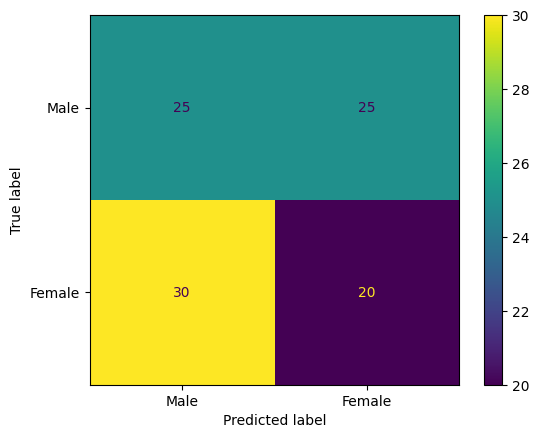

In [43]:
cm = confusion_matrix(img_test['Gender'], img_test['Prediction'], labels= labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=labels)
disp.plot()
plt.show()

In [33]:
from sklearn.metrics import accuracy_score,f1_score,recall_score,precision_score

In [44]:
accuracy_score(img_test['Gender'], img_test['Prediction'])

0.45

In [45]:
f1_score(img_test['Gender'].apply(lambda x : 1 if x=='Male' else 0), img_test['Prediction'].apply(lambda x : 1 if x=='Male' else 0))

0.47619047619047616

In [46]:
recall_score(img_test['Gender'].apply(lambda x : 1 if x=='Male' else 0), img_test['Prediction'].apply(lambda x : 1 if x=='Male' else 0))

0.5

In [47]:
precision_score(img_test['Gender'].apply(lambda x : 1 if x=='Male' else 0), img_test['Prediction'].apply(lambda x : 1 if x=='Male' else 0))

0.45454545454545453